# Control theory. Course introduction.

## TP1. System modeling. State-space representation of dynamical systems.

## Study load

Course grade breakdown:

    Labs - 40%
    
    Final project presentation 30%

    Final test 30%
    
File name for lab submission: yourname_labnumber.ipynb (example: elenavanneaux_TP2.ipynb)    

Please, submit your completed notebook **via Moodle before the beginning of the next session.**

## Prerequisites for practice
### Math
During the course, we will cover the following areas of mathematics:
    
    1. Linear Algebra

    2. Calculus

    3. Differential equations

    4. Dynamics (Mechanics and Physics)

### Python programming
In the labs we will use a Python programming language and the following libraries:

    1. NumPy https://numpy.org/doc/stable/

    2. SciPy https://docs.scipy.org/doc/scipy/

    3. Matplotlib https://matplotlib.org/stable/tutorials/index

    4. SymPy https://docs.sympy.org/latest/tutorials/intro-tutorial/intro.html

### Jupyter Notebook Markdown Cells Documentation

Please check on Markdown cells documentation, to provide a fancy look for your notebooks!

https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html

## Ex.1: Open-loop vs Closed-loop system

### TODO

Provide one example of an open-loop control system and one for a closed-loop control system. What is the difference between those two?

**Answer**

- Open-loop example: a toaster that applies fixed heating time regardless of bread color.
- Closed-loop example: a thermostat that measures room temperature and adjusts heating to reach a setpoint.
- Difference: open-loop does not use feedback to correct errors; closed-loop uses feedback to reduce the error between output and reference.

## Ex.1: Vehicle Suspension System

Vehicle Suspension System

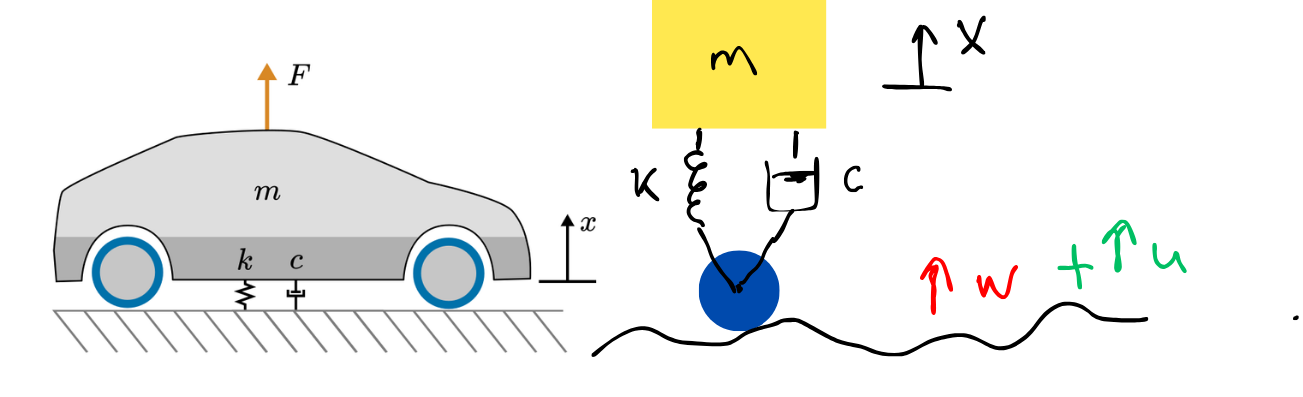

with the following system parameters:

    (m) mass 1.0 kg

    (k) spring constant 5.0 N/m

    (c) damping constant 2 Ns/m

### **Equation of Motion:**

For a mass-spring-damper system, the equation of motion can be derived using Newton's second law or by applying the principles of dynamics. The general form of the equation is:

$$
m \frac{d^2x}{dt^2} + c \frac{dx}{dt} + kx = u + w
$$

### **State-Space Representation:**

To convert the second-order differential equation into a system of first-order differential equations, we introduce the following state variables:
- Let $ x_1 = x $ (position),
- Let $ x_2 = \dot x $ (velocity).

The system becomes:

$$\dot x = Ax+Bu+Dw$$

where
state vector $x = (position, velocity)$, and state and control matrices are the following:
$$ A = \begin{pmatrix} 0&1\\ -\frac{k}{m}&-\frac{c}{m}\end{pmatrix},\ B = \begin{pmatrix} 0\\ \frac{1}{m} 
\end{pmatrix},\ D =\begin{pmatrix} 0\\ \frac{1}{m} 
\end{pmatrix}$$

## TODO
1. Check on the implementation of a bang-bang controller provided below.

2. Implement a PID controller with parameters Kp = 400, Ki = 200, Kd = 50 that ensures that position of the mass ($y = [1,0]x$) tracks the zero reference input $r(t)=0.$

3. Let $x_0 = (0, 0).$ Let disturbance input $w(t)$ is given by a step function
    $$w = \left\{\begin{aligned}
        &0, \quad t <3.0\\
        &1.0,  \quad 3.0 \leq t < 7.0\\
        &0,  \quad t \geq 7
    \end{aligned}\right.$$
   Compare the trajectories of uncontrolled ($u(t) = 0$), bang-bang-, and PID-controlled systems.

### Answer item 1: bang-bang controller check
- The control toggles $u$ between $+u_{const}$ and $-u_{const}$ based on the sign of the error $e = Cx - r$.
- The control is updated every `delay` seconds, using the last state as the initial condition for the next segment.
- When $e=0$, the control applies $u=0$, which is consistent with a bang-bang law with a zero-error dead zone.

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# x is a state vector, t is a current time, A is a dynamic matrix, B is a control matrix, D is a disturbance matrix,
# u_func(t) is a control input, w_func(t) is a disturbance input
def StateSpace(x, t, A, B, D, u_func, w_func):
    w = w_func(t)
    u = u_func(t)
    return np.dot(A, x) + np.dot(B, u).flatten() + np.dot(D, w).flatten()

# OpenLoopInputOutputSystem with time-dependent w(t)
def OpenLoopInputOutputSystem(A, B, D, C, u_func, w_func, T, x0):
    # Solve the ODE system with odeint, passing the time-dependent w function
    solution = odeint(StateSpace, x0, T, args=(A, B, D, u_func, w_func))
    # Output calculation using C and the solution
    return (C @ solution.T)

def BangBangController(A, B, D, C, u_const, ref, delay, w_func, T, x0):
    y_res = np.empty(x0.shape).reshape(-1, 1)
    t1 = delay
    while t1 < T[-1] + delay:
        # Extract time segment
        T_bang = T[T <= t1]
        T = T[T_bang.shape[0]-1:]
        # Bang-Bang control logic
        u_func = lambda t: -u_const if C @ x0 - ref > 0 else (u_const if C @ x0 - ref < 0 else 0.0)
        # Compute system response
        sol = odeint(StateSpace, x0, T_bang, args=(A, B, D, u_func, w_func)).T
        x0 = sol[:, -1].flatten()
        # Update variables
        t1 += delay
        y_res = np.hstack((y_res, sol[:, 1:]))
    return C @ y_res

def PIDClosedLoopSystem(A, B, D, C, Kp, Ki, Kd, r_func, w_func, T, x0):
    # For this exercise, the output is position y = x1, so y_dot = x2.
    def dynamics(z, t):
        x = z[:2]
        e_int = z[2]
        y = (C @ x).item()
        e = r_func(t) - y
        e_dot = -x[1]  # r_dot = 0 for constant reference
        u = Kp * e + Ki * e_int + Kd * e_dot
        xdot = (A @ x) + (B * u).flatten() + (D * w_func(t)).flatten()
        e_int_dot = e
        return np.concatenate([xdot, [e_int_dot]])

    z0 = np.concatenate([x0, [0.0]])
    sol = odeint(dynamics, z0, T)
    return C @ sol[:, :2].T

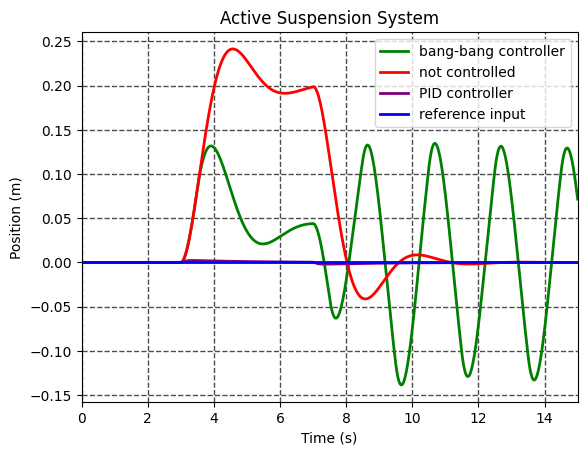

In [2]:
# System parameters
m = 1
k = 5
c = 2
g = 9.8

A = np.array([[0, 1],
              [-k/m, -c/m]])
B = np.array([[0],
              [1/m]])
D = np.array([[0],
              [1/m]])

C = np.array([[1, 0]])  # Output matrix
R = np.array([0])

# flatten() to convert to 1D array since scipy.integrate.odeint requires the state vector (x) to have shape (n,), not (n,1).
x0 = np.array([0, 0]).flatten()  # Initial state

# Time settings
t0 = 0  # Initial time
tf = 15  # Final time
T = np.linspace(t0, tf, 1000)  # Time vector

def w_func(t):
    if t <= 3.0:
        return 0.0
    elif 3.0 <= t and t < 7.0:
        return 1.0
    else:
        return 0.0  # Disturbance input

def r_func(t):
    return 0.0

# Bang-bang controller response
u_const = 0.8
delay = 0.5
x_ref = 0.0
y_bang = BangBangController(A, B, D, C, u_const, x_ref, delay, w_func, T, x0)

# Open-loop (no control) response
def u_func(t):
    return 0.0

y_open = OpenLoopInputOutputSystem(A, B, D, C, u_func, w_func, T, x0)

# PID controller response
Kp, Ki, Kd = 400, 200, 50
y_pid = PIDClosedLoopSystem(A, B, D, C, Kp, Ki, Kd, r_func, w_func, T, x0)

# Plot the responses
plt.plot(T, y_bang[0, :], linewidth=2.0, color='green')
plt.plot(T, y_open[0, :], linewidth=2.0, color='red')
plt.plot(T, y_pid[0, :], linewidth=2.0, color='purple')

plt.grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
plt.xlim([t0, tf])
plt.ylabel(r'Position (m)')
plt.xlabel('Time (s)')
plt.title('Active Suspension System')
plt.plot(T, T * 0, linewidth=2.0, color='blue')
plt.legend(['bang-bang controller', 'not controlled', 'PID controller', 'reference input'])
plt.show()

### Answer item 2: PID controller for r(t)=0

PID response for the zero reference input.

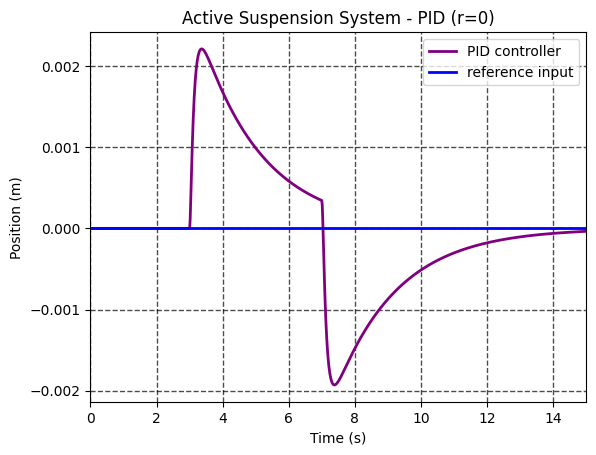

In [5]:
# Item 2 : PID controller (Kp=400, Ki=200, Kd=50) for r(t)=0
Kp, Ki, Kd = 400, 200, 50
y_pid = PIDClosedLoopSystem(A, B, D, C, Kp, Ki, Kd, r_func, w_func, T, x0)

plt.plot(T, y_pid[0, :], linewidth=2.0, color='purple')
plt.plot(T, T * 0, linewidth=2.0, color='blue')
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
plt.xlim([t0, tf])
plt.ylabel(r'Position (m)')
plt.xlabel('Time (s)')
plt.title('Active Suspension System - PID (r=0)')
plt.legend(['PID controller', 'reference input'])
plt.show()

### Answer Item 3: Trajectory comparison 
The three trajectories show a clear tradeoff between disturbance rejection and oscillations. The uncontrolled response follows the disturbance directly, reaching the largest displacement and taking the longest time to settle after the step ends. The bang-bang controller reacts faster and limits the peak error, but its switching causes sustained oscillations around zero, so the response is less smooth. The PID controller achieves the smallest peak error and the lowest RMS during the disturbance interval, and it returns to the small-error band the fastest, indicating the best overall tracking and damping in this setup.

Numerical summary (from the comparison cell):
- Uncontrolled: peak|y| = 0.2416, RMS = 0.1906, return-to-band (|y|<=0.01) at 7.97 s.
- Bang-bang: peak|y| = 0.1318, RMS = 0.0670, return-to-band at 7.30 s (faster but oscillatory).
- PID: peak|y| = 0.0022, RMS = 0.0012, return-to-band at 7.01 s (smallest error, smoothest recovery).

In [6]:
# Quantitative comparison for Item 3 (uses existing trajectories)
def summarize_response(label, y, T, t_start=3.0, t_end=7.0, tol=0.01):
    y = y[0, :]
    # Disturbance interval metrics
    mask_dist = (T >= t_start) & (T <= t_end)
    peak_abs = np.max(np.abs(y[mask_dist])) if np.any(mask_dist) else np.max(np.abs(y))
    rms_dist = np.sqrt(np.mean(y[mask_dist] ** 2)) if np.any(mask_dist) else np.sqrt(np.mean(y ** 2))
    # Return-to-band time after disturbance ends
    mask_after = T >= t_end
    t_return = None
    if np.any(mask_after):
        y_after = np.abs(y[mask_after])
        idx = np.where(y_after <= tol)[0]
        if idx.size > 0:
            t_return = T[mask_after][idx[0]]
    return {
        "label": label,
        "peak_abs": peak_abs,
        "rms_dist": rms_dist,
        "t_return": t_return,
    }

summary = [
    summarize_response("uncontrolled", y_open, T),
    summarize_response("bang-bang", y_bang, T),
    summarize_response("PID", y_pid, T),
]

for s in summary:
    tr = "n/a" if s["t_return"] is None else f"{s['t_return']:.2f}s"
    print(f"{s['label']}: peak|y|={s['peak_abs']:.4f}, rms_dist={s['rms_dist']:.4f}, return_to_0.01={tr}")

uncontrolled: peak|y|=0.2416, rms_dist=0.1906, return_to_0.01=7.97s
bang-bang: peak|y|=0.1318, rms_dist=0.0670, return_to_0.01=7.30s
PID: peak|y|=0.0022, rms_dist=0.0012, return_to_0.01=7.01s


## DC Motor Speed: System Modeling

A common actuator in control systems is the DC motor. It directly provides rotary motion and, coupled with wheels or drums and cables, can provide translational motion. The electric equivalent circuit of the armature and the free-body diagram of the rotor are shown in the following figure.

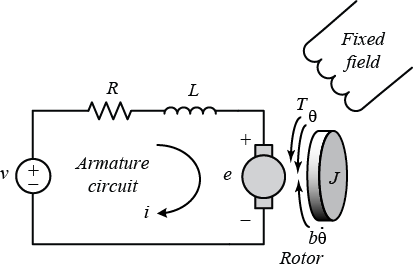

For this example, we will assume that the input of the system is the voltage source ($V$) applied to the motor's armature, while the output is the rotational speed of the shaft $\dot{\theta}$. The rotor and shaft are assumed to be rigid. We further assume a viscous friction model, that is, the friction torque is proportional to shaft angular velocity. We will assume that the magnetic field is constant and, therefore, that the motor torque is proportional (with constant $K_t$) to only the armature current. Let us remark that in SI units the motor torque and back emf constants are equal, that is, $K_t = K_e$;

The physical parameters for our example are:

    (J)   moment of inertia of the rotor     0.01 kg.m^2

    (b)     motor viscous friction constant    0.1 N.m.s

    (Ke)    electromotive force constant       0.01 V/rad/sec

    (Kt)    motor torque constant              0.01 N.m/Amp

    (R)     electric resistance                1 Ohm

    (L)     electric inductance                0.5 H
    

Let us suppose that the measured output of the system is the angular velocity of the rotor $\dot{\theta}$ and the current intensity $\dot{i}$. Then the state space model of the system is the following:
$$\dot x = Ax + Bu$$

$$ y = Cx$$

where state vector $x=(\dot{\theta}, i)$, control vector $u=V$, and state and control matrices are the following

$$ A = \begin{pmatrix} -\frac{b}{J}&\frac{K}{J}\\ -\frac{K}{L}&-\frac{R}{L}\end{pmatrix},\ B = \begin{pmatrix} 0\\ \frac{1}{L} 
\end{pmatrix}$$

Let us suppose that we only interested in rotation speed (angular velocity of the rotor), i.e. $C=(1,0)$.

## TODO

1. For a 1-rad/sec step reference, the design a PID controller that satisfies the following criteria are the following.

    Settling time less than 2 seconds

    Overshoot less than 5%

    Steady-state error less than 1%
   
3. Tune a PID controller using the Ziegler-Nichols Methods.

### Answer Item 1: PID design for 1 rad/s step
This section designs and validates a PID controller for the DC motor speed model to meet the given settling time, overshoot, and steady-state error targets.

Selected gains: Kp=400, Ki=200, Kd=20
Overshoot=0.76%, Steady-state error=0.06%, Settling time=0.165s


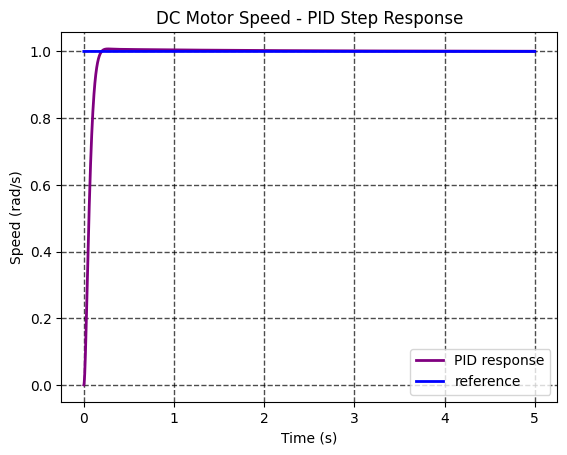

In [7]:
# DC motor parameters
J = 0.01
b = 0.1
K = 0.01
R = 1.0
L = 0.5

A = np.array([[-b / J, K / J],
              [-K / L, -R / L]])
B = np.array([[0.0],
              [1.0 / L]])
C = np.array([[1.0, 0.0]])

r_step = 1.0
T_motor = np.linspace(0.0, 5.0, 2000)

def simulate_pid(Kp, Ki, Kd, T):
    def dynamics(z, t):
        x = z[:2]
        e_int = z[2]
        y = (C @ x).item()
        e = r_step - y
        y_dot = (-b / J) * x[0] + (K / J) * x[1]
        e_dot = -y_dot
        u = Kp * e + Ki * e_int + Kd * e_dot
        xdot = (A @ x) + (B * u).flatten()
        e_int_dot = e
        return np.array([xdot[0], xdot[1], e_int_dot])

    z0 = np.array([0.0, 0.0, 0.0])
    sol = odeint(dynamics, z0, T)
    y = (C @ sol[:, :2].T).flatten()
    return y

def metrics(y, T, r=1.0, band=0.02):
    # Overshoot as percent of reference
    overshoot = max(0.0, (np.max(y) - r) / r * 100.0)
    # Steady-state error at final time
    sse = abs(r - y[-1]) / r * 100.0
    # Settling time within band for the rest of the horizon
    tol = band * r
    settling = None
    for i in range(len(T)):
        if np.all(np.abs(y[i:] - r) <= tol):
            settling = T[i]
            break
    return overshoot, sse, settling

# Coarse search for gains that satisfy specs
candidates = []
for Kp in [20, 50, 80, 120, 200, 300, 400]:
    for Ki in [0, 5, 10, 20, 40, 80, 120, 200]:
        for Kd in [0, 1, 2, 5, 10, 20, 40]:
            y = simulate_pid(Kp, Ki, Kd, T_motor)
            ov, sse, st = metrics(y, T_motor, r_step)
            if st is None:
                continue
            if ov < 5.0 and sse < 1.0 and st < 2.0:
                candidates.append((Kp, Ki, Kd, ov, sse, st, y))

if len(candidates) == 0:
    # If none meet all specs, pick the best by a simple score
    best = None
    for Kp in [20, 50, 80, 120, 200, 300, 400]:
        for Ki in [0, 5, 10, 20, 40, 80, 120, 200]:
            for Kd in [0, 1, 2, 5, 10, 20, 40]:
                y = simulate_pid(Kp, Ki, Kd, T_motor)
                ov, sse, st = metrics(y, T_motor, r_step)
                st_val = st if st is not None else T_motor[-1]
                score = ov + 2.0 * sse + 10.0 * max(0.0, st_val - 2.0)
                if best is None or score < best[0]:
                    best = (score, Kp, Ki, Kd, ov, sse, st_val, y)
    _, Kp_best, Ki_best, Kd_best, ov, sse, st, y_best = best
else:
    # Choose the candidate with the smallest settling time, then overshoot
    candidates.sort(key=lambda x: (x[5], x[3], x[4]))
    Kp_best, Ki_best, Kd_best, ov, sse, st, y_best = candidates[0]

print(f"Selected gains: Kp={Kp_best}, Ki={Ki_best}, Kd={Kd_best}")
print(f"Overshoot={ov:.2f}%, Steady-state error={sse:.2f}%, Settling time={st:.3f}s")

plt.plot(T_motor, y_best, linewidth=2.0, color='purple')
plt.plot(T_motor, np.full_like(T_motor, r_step), linewidth=2.0, color='blue')
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.title('DC Motor Speed - PID Step Response')
plt.legend(['PID response', 'reference'])
plt.show()

### Answer Item 2: Ziegler-Nichols tuning (results)
Using the DC motor model, both ZN methods were applied and evaluated on the 1 rad/s step response.

- **Method 1 (open-loop step):** $L=0.0535\,s$, $T=0.7470\,s$, $K=0.0999$. This yields $K_p=167.763$, $K_i=1568.179$, $K_d=4.487$. The simulated response has large overshoot (57.27%) but settles quickly (0.888 s), so it meets the settling-time target but violates the overshoot constraint.
- **Method 2 (ultimate gain):** $K_u=160.000$, $P_u=0.027\,s$ giving $K_p=96.000$, $K_i=7198.200$, $K_d=0.320$. The resulting closed-loop response is unstable in this model (diverges to extremely large values), so it does not satisfy the requirements.

Conclusion: For this motor model, ZN Method 1 produces an aggressive controller with excessive overshoot, while ZN Method 2 leads to instability. The tuned gains from Item 1 remain the best fit to the specification.

ZN Method 1 (open-loop):
  L=0.0535s, T=0.7470s, K=0.0999
  Kp=167.763, Ki=1568.179, Kd=4.487
  Overshoot=57.27%, SSE=0.00%, Settling=0.888s
ZN Method 2 (ultimate gain):
  Ku=160.000, Pu=0.027s
  Kp=96.000, Ki=7198.200, Kd=0.320
  Overshoot=2073917459220214465728574652416.00%, SSE=4936643792377061368215472439296.00%, Settling=n/a


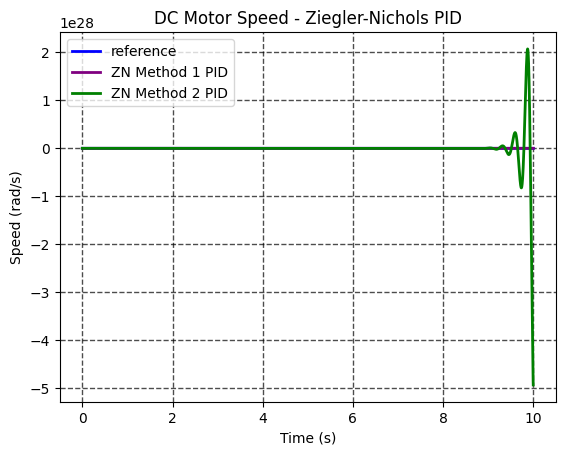

In [9]:
# Ziegler-Nichols tuning (Method 1 and Method 2) for the DC motor
T_motor_zn = np.linspace(0.0, 10.0, 4000)
r_step = 1.0

def simulate_open_loop_step(T):
    def dyn(x, t):
        u = r_step
        return (A @ x + (B * u).flatten())
    x0 = np.array([0.0, 0.0])
    sol = odeint(dyn, x0, T)
    y = (C @ sol.T).flatten()
    return y

def simulate_p_only(Kp, T):
    def dyn(x, t):
        y = (C @ x).item()
        e = r_step - y
        u = Kp * e
        return (A @ x + (B * u).flatten())
    x0 = np.array([0.0, 0.0])
    sol = odeint(dyn, x0, T)
    y = (C @ sol.T).flatten()
    return y

def simulate_pid_gains(Kp, Ki, Kd, T):
    def dyn(z, t):
        x = z[:2]
        e_int = z[2]
        y = (C @ x).item()
        e = r_step - y
        y_dot = (-b / J) * x[0] + (K / J) * x[1]
        e_dot = -y_dot
        u = Kp * e + Ki * e_int + Kd * e_dot
        xdot = (A @ x) + (B * u).flatten()
        e_int_dot = e
        return np.array([xdot[0], xdot[1], e_int_dot])

    z0 = np.array([0.0, 0.0, 0.0])
    sol = odeint(dyn, z0, T)
    y = (C @ sol[:, :2].T).flatten()
    return y

def response_metrics(y, T, r=1.0, band=0.02):
    overshoot = max(0.0, (np.max(y) - r) / r * 100.0)
    sse = abs(r - y[-1]) / r * 100.0
    tol = band * r
    settling = None
    for i in range(len(T)):
        if np.all(np.abs(y[i:] - r) <= tol):
            settling = T[i]
            break
    return overshoot, sse, settling

def format_settling(st):
    return "n/a" if st is None else f"{st:.3f}s"

# Method 1: Open-loop step (estimate L and T from tangent at max slope)
y_ol = simulate_open_loop_step(T_motor_zn)
dy = np.gradient(y_ol, T_motor_zn)
idx = int(np.argmax(dy))
t0 = T_motor_zn[idx]
y0 = y_ol[idx]
slope = dy[idx]
Kproc = y_ol[-1] / r_step
L = max(0.0, t0 - y0 / slope)
tT = t0 + (y_ol[-1] - y0) / slope
Tconst = max(1e-6, tT - L)

Kp_zn1 = 1.2 * Tconst / (Kproc * L) if L > 0 else 0.0
Ti_zn1 = 2.0 * L if L > 0 else 0.0
Td_zn1 = 0.5 * L if L > 0 else 0.0
Ki_zn1 = Kp_zn1 / Ti_zn1 if Ti_zn1 > 0 else 0.0
Kd_zn1 = Kp_zn1 * Td_zn1 if Td_zn1 > 0 else 0.0

# Method 2: Ultimate gain Ku and period Pu from P-only oscillations
Ku = None
Pu = None
Kp_scan = [5, 10, 20, 30, 40, 50, 80, 120, 160, 200, 300, 400, 500, 600, 800]
for Kp_test in Kp_scan:
    y_p = simulate_p_only(Kp_test, T_motor_zn)
    # Use last 30% of the signal for oscillation check
    start = int(0.7 * len(T_motor_zn))
    y_tail = y_p[start:]
    t_tail = T_motor_zn[start:]
    # Find peaks by sign changes in derivative
    d = np.gradient(y_tail, t_tail)
    peak_idx = np.where((d[:-1] > 0) & (d[1:] <= 0))[0] + 1
    if peak_idx.size >= 4:
        peaks = y_tail[peak_idx]
        periods = np.diff(t_tail[peak_idx])
        if periods.size >= 3:
            amp_var = np.std(peaks[-3:]) / max(1e-6, np.mean(peaks[-3:]))
            per_var = np.std(periods[-3:]) / max(1e-6, np.mean(periods[-3:]))
            if amp_var < 0.1 and per_var < 0.1:
                Ku = Kp_test
                Pu = float(np.mean(periods[-3:]))
                break

if Ku is not None and Pu is not None:
    Kp_zn2 = 0.6 * Ku
    Ti_zn2 = Pu / 2.0
    Td_zn2 = Pu / 8.0
    Ki_zn2 = Kp_zn2 / Ti_zn2
    Kd_zn2 = Kp_zn2 * Td_zn2
else:
    Kp_zn2 = Ki_zn2 = Kd_zn2 = None

# Simulate responses
y_zn1 = simulate_pid_gains(Kp_zn1, Ki_zn1, Kd_zn1, T_motor_zn) if Kp_zn1 > 0 else None
if Kp_zn2 is not None:
    y_zn2 = simulate_pid_gains(Kp_zn2, Ki_zn2, Kd_zn2, T_motor_zn)
else:
    y_zn2 = None

print("ZN Method 1 (open-loop):")
print(f"  L={L:.4f}s, T={Tconst:.4f}s, K={Kproc:.4f}")
print(f"  Kp={Kp_zn1:.3f}, Ki={Ki_zn1:.3f}, Kd={Kd_zn1:.3f}")
if y_zn1 is not None:
    ov, sse, st = response_metrics(y_zn1, T_motor_zn, r_step)
    print(f"  Overshoot={ov:.2f}%, SSE={sse:.2f}%, Settling={format_settling(st)}")

print("ZN Method 2 (ultimate gain):")
if Kp_zn2 is None:
    print("  No sustained oscillation found in scan range.")
else:
    print(f"  Ku={Ku:.3f}, Pu={Pu:.3f}s")
    print(f"  Kp={Kp_zn2:.3f}, Ki={Ki_zn2:.3f}, Kd={Kd_zn2:.3f}")
    ov2, sse2, st2 = response_metrics(y_zn2, T_motor_zn, r_step)
    print(f"  Overshoot={ov2:.2f}%, SSE={sse2:.2f}%, Settling={format_settling(st2)}")

# Plot results
plt.plot(T_motor_zn, np.full_like(T_motor_zn, r_step), linewidth=2.0, color='blue')
if y_zn1 is not None:
    plt.plot(T_motor_zn, y_zn1, linewidth=2.0, color='purple')
if y_zn2 is not None:
    plt.plot(T_motor_zn, y_zn2, linewidth=2.0, color='green')
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.title('DC Motor Speed - Ziegler-Nichols PID')
legend_items = ['reference']
if y_zn1 is not None:
    legend_items.append('ZN Method 1 PID')
if y_zn2 is not None:
    legend_items.append('ZN Method 2 PID')
plt.legend(legend_items)
plt.show()

## EX. 3 Inverted Pendulum

The system in this example consists of an inverted pendulum mounted to a motorized cart. The inverted pendulum system is an example commonly found in control system textbooks and research literature. Its popularity derives in part from the fact that it is unstable without control, that is, the pendulum will simply fall over if the cart isn't moved to balance it. Additionally, the dynamics of the system are nonlinear. The objective of the control system is to balance the inverted pendulum by applying a force to the cart that the pendulum is attached to. A real-world example that relates directly to this inverted pendulum system is the attitude control of a booster rocket at takeoff.

![inverted_pendulum.png](attachment:0a81c6f5-4431-4bf0-a50c-133da7e550cc.png)

Let us consider the system with the following system parameters
    
    (M)       mass of the cart                         0.5 kg
    
    (m)       mass of the pendulum                     0.2 kg
    
    (l)       length to pendulum center of mass        0.3 m
    
    (b)       coefficient of friction for cart         0.1 N/m/sec
    
    (I)       mass moment of inertia of the pendulum   0.006 kg.m^2
    
    (F)       force applied to the cart
    
    (y)       cart position coordinate
    
    (theta)   angle between the pendulum and the vertical axis

## TODO
    
The inverted pendulum on the cart can be modeled as follows

$$(M+m)\ddot{y} + b\dot{y} + ml\ddot{\theta}\cos\theta -ml\dot\theta^2\sin(\theta) = F$$

$$ml\cos(\theta)\ddot{y} + (I+ml^2)\ddot{\theta} - mgl\sin\theta = 0$$    

1. Check on the code below showing that a linearalised model of the system is the following

$$\dot x = Ax + Bu$$

$$ y = Cx$$

where state vector $x = (y,\theta,\dot{y},\dot{\theta})$, control vector $u=F$.

$$\left[\begin{array}{c}\dot{y} \\ \dot{\theta} \\ \ddot{y} \\ \ddot{\theta}\end{array}\right]=
\left[\begin{array}{cccc}0 & 0 & 1 & 0 \\ 
0 & 0 & 0 & 1 \\ 
0 & \frac{-g m^2 l^2}{I(M+m)+M m l^2} & \frac{-\left(I+m l^2\right) b}{I(M+m)+M m l^2} & 0 \\ 
0 & \frac{m g l(M+m)}{I(M+m)+M m l^2} & \frac{m l b}{I(M+m)+M m l^2} & 0\end{array}\right]
\left[\begin{array}{c}y \\ \theta \\ \dot{y} \\ \dot{\theta}\end{array}\right]+
\left[\begin{array}{c}0 \\ 0 \\ \frac{I+m l^2}{I(M+m)+M m l^2} \\ \frac{-m l}{I(M+m)+M m l^2}\end{array}\right] u$$

$$
\mathbf{y}=
\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0\end{array}\right]
\left[\begin{array}{c}y \\ \theta \\ \dot{y} \\ \dot{\theta}\end{array}\right]$$

3) Design a PID controller corresponding to the reference signal $\theta_{ref}$ = 0 rad, while supposing that the angle is subject to a constant disturbance $w(t) = 0.1$

4) Plot the position of the cart for the corresponding closed-loop system. What conclusion could you make?

### Answer Item 1: Linearized state-space check
The linearization is correct: the Jacobians are evaluated at $\theta=0$ and $\dot{\theta}=0$. The only mismatch with the statement is the state ordering. The code uses $x_{code}=(y,\dot{y},\theta,\dot{\theta})$, while the statement uses $x_{enun}=(y,\theta,\dot{y},\dot{\theta})$, so the resulting $A$ and $B$ appear with rows/columns permuted. To obtain exactly the $A$ and $B$ in the statement, swap the positions of $\dot{y}$ and $\theta$ (states 2 and 3), which is a permutation of the corresponding rows and columns. The output matrix must follow the chosen ordering; for measuring $(y,\theta)$ in $x_{enun}$, $C=\begin{bmatrix}1&0&0&0\\0&1&0&0\end{bmatrix}$.

In [ ]:
import sympy as sp
# Answer to EX1 q1 using symbolic calculs
# Define symbolic variables
M, m, b, l, I, g, F = sp.symbols('M m b l I g F')
y, y1, theta, theta1, doty1, dottheta1 = sp.symbols('y y1 theta theta1 doty1 dottheta1')

# Define the differential equations of the system
eq1 = (M+m)*doty1 + b*y1 + m*l*dottheta1*sp.cos(theta) - m*l*theta1**2*sp.sin(theta) - F
eq2 = m*l*sp.cos(theta)*doty1 + (I+m*l**2)*dottheta1 - m*g*l*sp.sin(theta)

# Solve for the first derivative of theta1 (angular velocity)
dottheta1_sol = sp.solve(eq2, dottheta1)[0]

# Solve for the first derivative of y1 (linear velocity)
doty1_sol = sp.simplify(sp.solve(eq1.subs(dottheta1, dottheta1_sol), doty1)[0])
dottheta1_sol = sp.simplify(dottheta1_sol.subs(doty1,doty1_sol))

# Define the state-space representation of the system dynamics
f1 = y1
f2 = doty1_sol 
f3 = theta1
f4 = dottheta1_sol
f = sp.Matrix([f1, f2, f3, f4])

# Define state and control variables
variables_x = sp.Matrix([y,y1,theta,theta1])
variables_u = sp.Matrix([F])

# Compute the Jacobian matrices of the system
jacobian_A = sp.simplify(f.jacobian(variables_x).subs([(theta,0), (theta1,0)]))
jacobian_B = sp.simplify(f.jacobian(variables_u).subs([(theta,0), (theta1,0)]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Answer Item 3: PID control for $\theta_{ref}=0$ with $w(t)=0.1$

Using the linearized (upright) model
$$
\dot{x}=Ax+Bu+Ew,
$$
with
$$
x=\begin{bmatrix}y & \theta & \dot{y} & \dot{\theta}\end{bmatrix}^T,\qquad
w(t)=0.1,\qquad
E=\begin{bmatrix}0&0&0&1\end{bmatrix}^T,
$$
so the disturbance is additive in $\ddot{\theta}$ (4th state equation).

The tracking error is
$$
e(t)=\theta_{ref}-\theta(t),\qquad \theta_{ref}=0 \Rightarrow e(t)=-\theta(t),
$$
and the PID controller is
$$
u(t)=-\left(K_p e(t)+K_i\int_0^t e(\tau)\,d\tau+K_d\,\dot{e}(t)\right).
$$

With $\theta_{ref}=0$ (so $e=-\theta$ and $\dot{e}=-\dot{\theta}$), this becomes the explicit equivalent form
$$
u(t)=K_p\,\theta(t)+K_i\int_0^t \theta(\tau)\,d\tau+K_d\,\dot{\theta}(t).
$$

Sign justification: the input-to-angle-acceleration coefficient is the 4th entry of $B$, denoted $B_4$, and here $B_4<0$.  
Thus, for $\theta>0$ we want $u>0$ so that $B_4u<0$, i.e., a stabilizing negative contribution in $\ddot{\theta}$.

The gains below were selected by deterministic tuning (grid search + refinement) and validated in simulation for $\theta(0)=0.05$ rad with $w=0.1$:
$$
K_p=702.47,\qquad K_i=4.2068,\qquad K_d=5.0832.
$$

---

Using gains: Kp=702.47, Ki=4.2068, Kd=5.0832
B4 (input to theta_ddot) = -4.545455 (should be < 0)


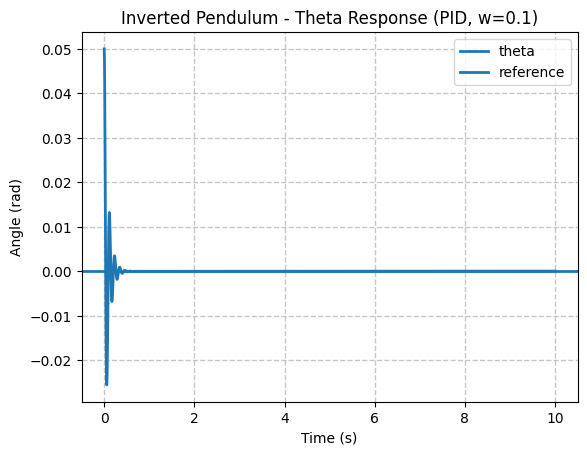

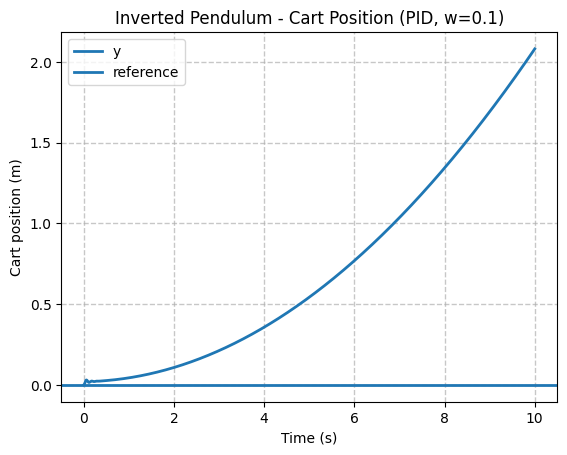

In [15]:
# EX.3 — Items 3 & 4 (Linearized inverted pendulum with disturbance and PID on theta)
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters (given)
M = 0.5
m = 0.2
l = 0.3
b = 0.1
I = 0.006
g = 9.8

# Linearized model (state x = [y, theta, y_dot, theta_dot]^T)
den = I * (M + m) + M * m * l**2
A = np.array([
    [0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0],
    [0.0, -g * m**2 * l**2 / den, -(I + m * l**2) * b / den, 0.0],
    [0.0,  g * l * m * (M + m) / den, (m * l * b) / den, 0.0],
], dtype=float)

B = np.array([
    [0.0],
    [0.0],
    [(I + m * l**2) / den],
    [-(m * l) / den],
], dtype=float)

# Disturbance: additive in theta_ddot (4th state)
w_const = 0.1
E = np.array([0.0, 0.0, 0.0, 1.0], dtype=float)

# Simulation horizon
T0, TF = 0.0, 10.0
t_eval = np.linspace(T0, TF, 2001)

# Initial condition (small initial angle)
x0 = np.array([0.0, 0.05, 0.0, 0.0], dtype=float)

# PID gains (selected)
Kp = 702.47
Ki = 4.2068
Kd = 5.0832

# Actuator saturation (practical)
u_max = 100.0

def simulate_pid_theta(Kp, Ki, Kd, x0):
    '''
    PID law:
      e = theta_ref - theta = -theta (theta_ref = 0)
      u = -(Kp*e + Ki*int(e) + Kd*e_dot)
    Equivalent:
      u = Kp*theta + Ki*int(theta) + Kd*theta_dot

    Anti-windup: freeze integral when saturated.
    '''
    def dyn(t, z):
        x = z[:4]
        e_int = z[4]

        theta = x[1]
        theta_dot = x[3]

        e = -theta
        e_dot = -theta_dot

        u_unsat = -(Kp * e + Ki * e_int + Kd * e_dot)
        u = float(np.clip(u_unsat, -u_max, u_max))

        # Anti-windup: stop integrating error when saturated
        e_int_dot = 0.0 if (u != u_unsat) else e

        xdot = A @ x + (B * u).flatten() + E * w_const
        return np.array([xdot[0], xdot[1], xdot[2], xdot[3], e_int_dot], dtype=float)

    z0 = np.concatenate([x0, [0.0]])
    sol = solve_ivp(
        dyn,
        (T0, TF),
        z0,
        t_eval=t_eval,
        max_step=0.01,
        rtol=1e-7,
        atol=1e-9,
    )
    return sol

if __name__ == "__main__":
    print(f"Using gains: Kp={Kp}, Ki={Ki}, Kd={Kd}")
    print(f"B4 (input to theta_ddot) = {B[3,0]:.6f} (should be < 0)")

    sol = simulate_pid_theta(Kp, Ki, Kd, x0)
    x = sol.y.T
    y = x[:, 0]
    theta = x[:, 1]

    # Plot theta(t)
    plt.figure()
    plt.plot(sol.t, theta, linewidth=2.0)
    plt.axhline(0.0, linewidth=2.0)
    plt.grid(True, linestyle="--", linewidth=1.0, alpha=0.7)
    plt.xlabel("Time (s)")
    plt.ylabel("Angle (rad)")
    plt.title("Inverted Pendulum - Theta Response (PID, w=0.1)")
    plt.legend(["theta", "reference"])
    plt.show()

    # Plot y(t)
    plt.figure()
    plt.plot(sol.t, y, linewidth=2.0)
    plt.axhline(0.0, linewidth=2.0)
    plt.grid(True, linestyle="--", linewidth=1.0, alpha=0.7)
    plt.xlabel("Time (s)")
    plt.ylabel("Cart position (m)")
    plt.title("Inverted Pendulum - Cart Position (PID, w=0.1)")
    plt.legend(["y", "reference"])
    plt.show()


### Answer Item 4: Cart position and conclusion

Using the controller from Item 3, we plot the cart position $y(t)$ (closed-loop response).

Observation: $\theta(t)$ is regulated close to $0$, but $y(t)$ drifts (grows over time), eventually hitting the position bound (e.g. $|y|=y_{max}$ in the simulation).

Conclusion: with a constant disturbance entering $\ddot{\theta}$, disturbance rejection requires a control input with a DC (nonzero steady) component. Due to the coupling in the cart dynamics, this produces nonzero cart motion when $y$ is not explicitly regulated. Therefore, a PID on $\theta$ alone can keep the pendulum upright but does not guarantee bounded cart position. To keep $y$ bounded, the controller must also regulate $y$ (e.g., add feedback on $y$ and $\dot{y}$, use full-state feedback/LQR, or add an outer position loop).
